# Overview

This notebook implements an early evaluation of the strength of the theoretical gateway aggregator model using experimental results.
Compares single experimental setups with the Pinciroli's (2023) theoretical results to generate an intuition of their relationship.


It visualizes the results, calculates the _mean average (percentage) error_ between the results, suggesting how 'off' the results are.
It also calculates Pearson's $r$ to understand the correlation between results.


In [1]:
import datetime
import json
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr


pincirollis_data_path = "/workspaces/muBench-experiment/gssi_experiment/gateway_aggregator/pincirolli_results.csv"
synth_df = pd.read_csv(pincirollis_data_path, header=0)
synth_df.describe()

# results_base_path = '/workspaces/muBench-experiment/gssi_experiment/gateway_aggregator/results/2023_11_13/results/2023_11_10/1000m_1rep_25trials/run_1/'
# results_base_path = '/workspaces/muBench-experiment/gssi_experiment/gateway_aggregator/results/2023_11_13/results/2023_11_11/750m_1rep_25trials/run_1/'
# results_base_path = '/workspaces/muBench-experiment/gssi_experiment/gateway_aggregator/results/2023_11_13/results/2023_11_11/1250m_1rep_25trials/run_1/'
results_base_path = "/workspaces/muBench-experiment/gssi_experiment/gateway_aggregator/results/2023_11_13/results/2023_11_12/500m_1rep_25trials/run_1/"

# Request Delay


## Dataframe creation

In [2]:
# Generates data from the step data

service_cols = ["s3_intensity", "avg_latency_ms"]
df = pd.DataFrame(columns=service_cols)

max_steps = 25
for step in range(max_steps + 1):
    path = f"{results_base_path}/{step}_steps/mubench_results.csv"
    if not os.path.exists(path):
        print(f'Could not load data from path "{path}"')
        continue
    exp_df = pd.read_csv(path, header=0)
    avg_latency = np.average(exp_df["latency_ms"])
    s3_intensity = 1 - (step / max_steps)
    df.at[step, "s3_intensity"] = s3_intensity
    df.at[step, "avg_latency_ms"] = avg_latency

In [3]:
pinc_df = synth_df[["N_A", "R0"]]
pinc_df.loc[:, "s3_intensity"] = pinc_df["N_A"].transform(lambda x: x / 25)
pinc_df = pinc_df.drop("N_A", axis=1)

df = pd.merge(df, pinc_df, on="s3_intensity")

df

/tmp/ipykernel_77271/1627540373.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pinc_df.loc[:, "s3_intensity"] = pinc_df["N_A"].transform(lambda x: x / 25)


,s3_intensity,avg_latency_ms,R0
0,1.0,6059.2254,501.080456
1,0.96,6126.240467,479.255831
2,0.92,5987.687533,442.471346
3,0.88,6108.2082,423.019923
4,0.84,3878.275867,398.736891
5,0.8,3269.1374,387.771535
6,0.76,3859.0696,373.134026
7,0.72,4614.970667,363.374229
8,0.64,3662.3026,348.906502
9,0.6,3503.557067,349.225049


## Visualization


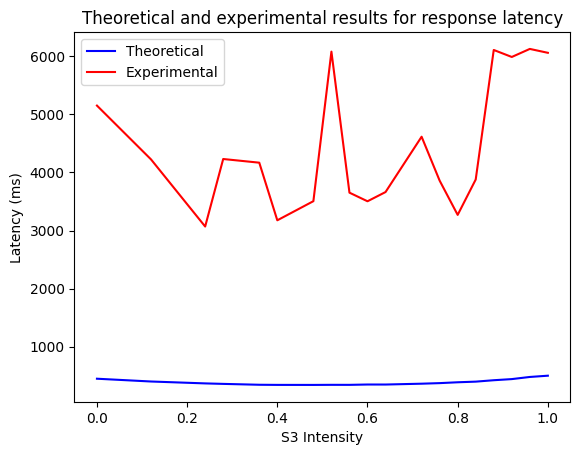

In [4]:
# Create a figure and axis
plt.figure()
ax = plt.axes()

# Plot the first line (sine function)
ax.plot(df["s3_intensity"], df["R0"], label="Theoretical", color="blue")

# Plot the second line (cosine function)
ax.plot(df["s3_intensity"], df["avg_latency_ms"], label="Experimental", color="red")

# Add labels and a legend
ax.set_ylabel("Latency (ms)")
ax.set_xlabel("S3 Intensity")
ax.set_title("Theoretical and experimental results for response latency")
ax.legend()

# Show the plot
plt.show()

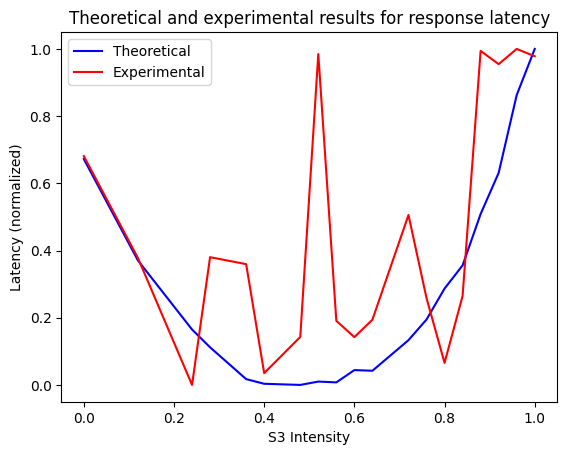

In [5]:
# Normalized data


def normalize(x, x_min, x_max):
    x -= x_min
    x /= x_max - x_min
    return x


df_norm = pd.DataFrame()
df_norm["s3_intensity"] = df["s3_intensity"]

r0_min, r0_max = min(df["R0"]), max(df["R0"])
df_norm["R0"] = df["R0"].transform(lambda x: normalize(x, r0_min, r0_max))

lat_min, lat_max = min(df["avg_latency_ms"]), max(df["avg_latency_ms"])
df_norm["avg_latency_ms"] = df["avg_latency_ms"].transform(
    lambda x: normalize(x, lat_min, lat_max)
)


# Create a figure and axis
plt.figure()
ax = plt.axes()

# Plot the first line (sine function)
ax.plot(df_norm["s3_intensity"], df_norm["R0"], label="Theoretical", color="blue")

# Plot the second line (cosine function)
ax.plot(
    df_norm["s3_intensity"],
    df_norm["avg_latency_ms"],
    label="Experimental",
    color="red",
)

# Add labels and a legend
ax.set_ylabel("Latency (normalized)")
ax.set_xlabel("S3 Intensity")
ax.set_title("Theoretical and experimental results for response latency")
ax.legend()

# Show the plot
plt.show()

## Evaluation


### Compares the delay data set using MAPE and Spearman's r


In [6]:
correlation_coefficient, p_value = spearmanr(df["R0"], df["avg_latency_ms"])

# Display the result
print(f"Spearman's correlation coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

Spearman's correlation coefficient: 0.5736842105263157
P-value: 0.010222581046377573


### Mean average percentage error

Intuitively, how off the result is on average.

$\displaystyle M = \frac{1}{n}\sum^n_{t=1} \bigg|\frac{A_t - F_t}{A_t}\bigg|$

Where $n$ is the number of elements, $F_t$ the forecast value, and $A_t$ the actual value.


In [7]:
def mape(expected, real) -> float:
    m = 0
    for real_ele, expected_ele in zip(expected, real):
        m += abs((real_ele - expected_ele) / expected_ele)
    m /= len(expected)
    return m


absolute_mape = mape(df["R0"], df["avg_latency_ms"])
eps = 1
normalized_mape = mape(df_norm["R0"] + eps, df_norm["avg_latency_ms"] + eps)

print(f"{absolute_mape=}, {normalized_mape=} ({eps=})")

absolute_mape=0.9093667886243174, normalized_mape=0.14218805400694 (eps=1)


### Mean absolute error

$\displaystyle M = \frac{1}{n}\sum^n_{t=1}\bigg|A_t - F_t\bigg|$

Where $n$ is the number of elements, $F_t$ the forecast value, and $A_t$ the actual value.


In [8]:
def mae(expected, real) -> float:
    m = 0
    for real_ele, expected_ele in zip(expected, real):
        m += abs((real_ele - expected_ele))
    m /= len(expected)
    return m


absolute_mae = mae(df["R0"], df["avg_latency_ms"])
normalized_mae = mae(df_norm["R0"], df_norm["avg_latency_ms"])

print(f"{absolute_mae=}, {normalized_mae=}")

absolute_mae=4050.5932039576815, normalized_mae=0.21530085629938905


# CPU Utilization

## Dataframe creation

In [9]:
TIME_FORMAT = "%Y-%m-%dT%H:%M:%S.000Z"
TIMEFORMAT_2 = "%Y-%m-%d %H:%M:%S"


def lies_outside_timewindow(
    timestamp: str, start: datetime.date, end: datetime.datetime
) -> bool:
    """Returns true if the provided timestamp lies outside the provided window."""
    timestamp = datetime.datetime.strptime(timestamp, TIMEFORMAT_2)
    return timestamp < start and timestamp > end


# Generates data from the step data
service_cols = ["gateway-aggregator", "s1", "s2", "s3"]
cols = [*service_cols, "s3_intensity", "n"]
df = pd.DataFrame(columns=cols)

max_steps = 25
for step in range(max_steps + 1):
    experiment_base_path = f"{results_base_path}/{step}_steps/"
    if not os.path.exists(experiment_base_path):
        print(f'Could not load data from path "{experiment_base_path}"')
        continue

    # Reads the start and end time to filter CPU utilization.
    with open(
        f"{experiment_base_path}/metadata.json", "r", encoding="utf-8"
    ) as metadata_file:
        j_data = json.loads(metadata_file.read())
    start_time = datetime.datetime.strptime(j_data["start_time"], TIME_FORMAT)
    end_time = datetime.datetime.strptime(j_data["end_time"], TIME_FORMAT)

    # Filters CPU utilization features by using the experiment's time window.
    exp_df = pd.read_csv(f"{experiment_base_path}/cpu_utilization.csv", header=0)
    indices_outside_timewindow = [
        index
        for index in exp_df.index
        if lies_outside_timewindow(index, start_time, end_time)
    ]
    exp_df = exp_df.drop(indices_outside_timewindow)

    # Some reading can be incomplete; these are dropped.
    exp_df = exp_df.dropna()

    # Constructs average CPU utilization datapoint.
    data_point = [np.average(exp_df[col]) for col in service_cols]

    # Adds the number of CPU utilization data points as this might explain distribution in the results.
    n = len(exp_df)
    s3_intensity = 1 - (step / max_steps)
    data_point = [*data_point, s3_intensity, n]
    df.loc[step, cols] = data_point

df

,gateway-aggregator,s1,s2,s3,s3_intensity,n
0,0.01964,0.127854,0.291759,0.463935,1.0,50
1,0.01906,0.12407,0.284837,0.456551,0.96,50
2,0.020921,0.143461,0.313929,0.495941,0.92,49
3,0.020979,0.129134,0.307794,0.484338,0.88,50
4,0.02831,0.160712,0.432335,0.466563,0.84,33
5,0.0354,0.443175,0.473693,0.47199,0.8,28
6,0.029374,0.252323,0.449366,0.466368,0.76,33
7,0.024948,0.181632,0.362973,0.47378,0.72,38
8,0.031177,0.239154,0.442787,0.473657,0.68,31
9,0.029405,0.204851,0.407959,0.469517,0.64,31


In [10]:
pinc_df = synth_df[["N_A", "Ugw", "Us1", "Us2", "Us3"]]
pinc_df.loc[:, "s3_intensity"] = pinc_df["N_A"].transform(lambda x: x / 25)
pinc_df = pinc_df.drop("N_A", axis=1)

df = pd.merge(df, pinc_df, on="s3_intensity")

df

/tmp/ipykernel_77271/3698107938.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pinc_df.loc[:, "s3_intensity"] = pinc_df["N_A"].transform(lambda x: x / 25)


,gateway-aggregator,s1,s2,s3,s3_intensity,n,Ugw,Us1,Us2,Us3
0,0.01964,0.127854,0.291759,0.463935,1.0,50,0.498132,0.350410,0.739736,1.000000
1,0.01906,0.12407,0.284837,0.456551,0.96,50,0.531565,0.409539,0.770667,1.000000
2,0.020921,0.143461,0.313929,0.495941,0.92,49,0.566388,0.494077,0.824476,0.999735
3,0.020979,0.129134,0.307794,0.484338,0.88,50,0.593402,0.552470,0.848254,1.000000
4,0.02831,0.160712,0.432335,0.466563,0.84,33,0.613210,0.612301,0.887285,0.999280
5,0.0354,0.443175,0.473693,0.47199,0.8,28,0.645042,0.665800,0.910665,0.999964
6,0.029374,0.252323,0.449366,0.466368,0.76,33,0.666261,0.720328,0.935504,0.998358
7,0.024948,0.181632,0.362973,0.47378,0.72,38,0.684428,0.761235,0.951787,0.987397
8,0.029405,0.204851,0.407959,0.469517,0.64,31,0.705691,0.826898,0.972755,0.976939
9,0.031721,0.202854,0.452602,0.444654,0.6,30,0.716111,0.859453,0.985620,0.951204


## Visualization

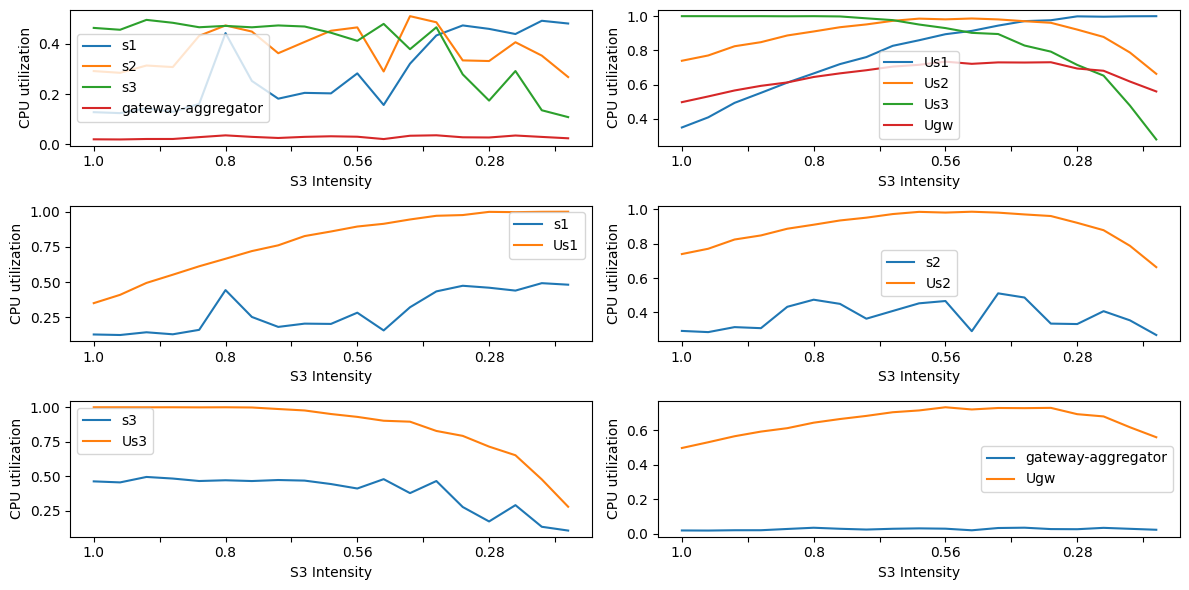

In [11]:
def plot_comparisons(comparison_tuples, df):
    # Calculate the number of subplots based on the length of comparison_tuples
    num_subplots = len(comparison_tuples)
    # Determine the number of rows and columns for the subplots
    num_rows = num_subplots // 2  # Assuming 2 columns
    num_cols = 2  # Number of columns for the subplots

    # Create a larger figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

    # Flatten the axes array if there is more than one row
    axes = axes.flatten() if num_rows > 1 else [axes]

    for i, columns in enumerate(comparison_tuples):
        # Select the current subplot
        ax = axes[i]

        # Plot a line diagram for each pair of columns in the DataFrame
        x_column = "s3_intensity"
        for column in columns:
            df.plot(x=x_column, y=column, ax=ax)

        ax.set_xlabel("S3 Intensity")
        ax.set_ylabel("CPU utilization")

    # Adjust layout to prevent overlapping titles
    plt.tight_layout()
    plt.show()


comparison_tuples = [
    ("s1", "s2", "s3", "gateway-aggregator"),
    ("Us1", "Us2", "Us3", "Ugw"),
    ("s1", "Us1"),
    ("s2", "Us2"),
    ("s3", "Us3"),
    ("gateway-aggregator", "Ugw"),
]
plot_comparisons(comparison_tuples, df)

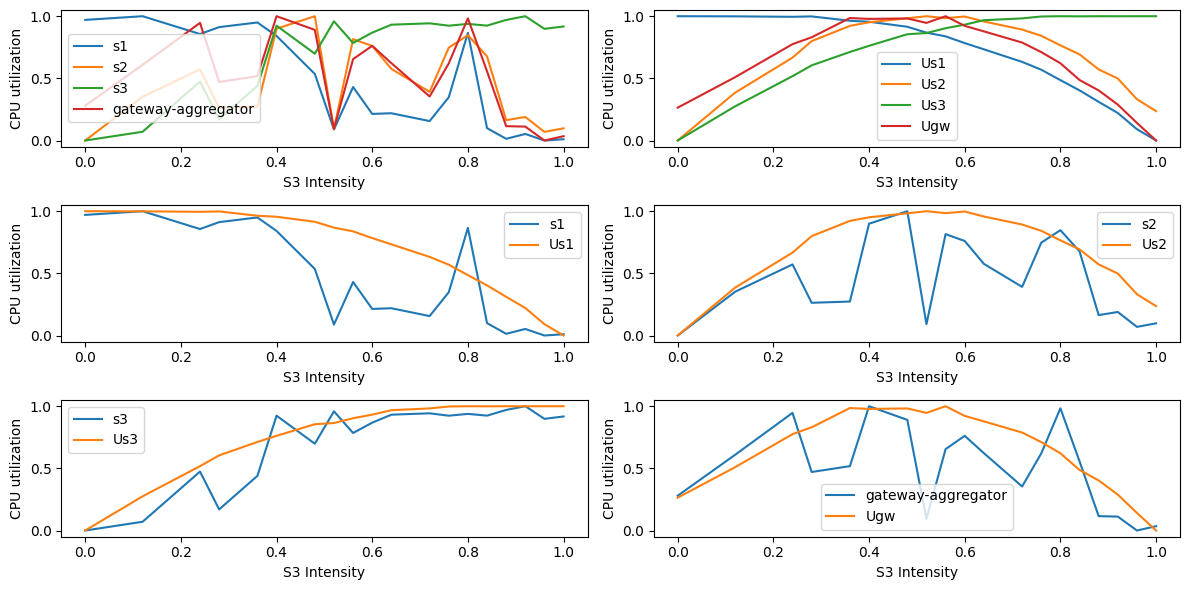

In [12]:

norm_df = pd.DataFrame()

for col in df.columns:
    min_x, max_x = min(df[col]), max(df[col])
    norm_df[col] = df[col].transform(lambda x: normalize(x, min_x, max_x))

comparison_tuples = [
    ("s1", "s2", "s3", "gateway-aggregator"),
    ("Us1", "Us2", "Us3", "Ugw"),
    ("s1", "Us1"),
    ("s2", "Us2"),
    ("s3", "Us3"),
    ("gateway-aggregator", "Ugw"),
]
plot_comparisons(comparison_tuples, norm_df)

## Evaluation

In [13]:
comparison_tuples = [
    ("s1", "Us1"),
    ("s2", "Us2"),
    ("s3", "Us3"),
    ("gateway-aggregator", "Ugw"),
]

### Spearman's correlation coefficient

In [14]:
for real, expected in comparison_tuples:
    correlation_coefficient, p_value = spearmanr(df[expected], df[real])

    # Display the result
    print(
        f"Spearman's correlation coefficient {real}: {correlation_coefficient} ({p_value=})"
    )

Spearman's correlation coefficient s1: 0.8578947368421052 (p_value=2.6477931032626356e-06)
Spearman's correlation coefficient s2: 0.5754385964912281 (p_value=0.009940816036902564)
Spearman's correlation coefficient s3: 0.7152910870852874 (p_value=0.0005759080758733536)
Spearman's correlation coefficient gateway-aggregator: 0.5666666666666667 (p_value=0.011414828523297841)


### Mean average (percentage) error

In [15]:
for real, expected in comparison_tuples:
    mape_score = mape(df[expected], df[real])
    mae_score = mae(df[expected], df[real])
    print(f"{real}: {mape_score=}, {mae_score=}")

    eps = 1
    norm_mape_score = mape(norm_df[expected] + eps, norm_df[real] + eps)
    norm_mae_score = mae(norm_df[expected], norm_df[real])
    print(f"{real}: {norm_mape_score=} ({eps=}), {norm_mae_score=}\n")

s1: mape_score=2.1149131398317986, mae_score=0.4966645531998589
s1: norm_mape_score=0.20814965573145805 (eps=1), norm_mae_score=0.2622871045883509

s2: mape_score=1.4107227345626583, mae_score=0.5123329023634926
s2: norm_mape_score=0.2003658752330517 (eps=1), norm_mae_score=0.25733675674184076

s3: mape_score=1.3540050270477286, mae_score=0.47214938264114964
s3: norm_mape_score=0.07197491879493063 (eps=1), norm_mae_score=0.10802154470314129

gateway-aggregator: mape_score=23.39039334848202, mae_score=0.6263211226790485
gateway-aggregator: norm_mape_score=0.1687817455912601 (eps=1), norm_mae_score=0.2335863985166462

